# #1 Emissions Datathon - Permian, Mean Pixel values and CNN

### Prepare Dataframe

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
image_train = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train')

dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'csv'

In [3]:
filepaths = pd.Series(list(image_train.glob(r'**/*.png')), name='Filepath').astype(str)

In [4]:
filepaths.head()

0    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
1    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
2    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
3    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
4    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
Name: Filepath, dtype: object

In [5]:
df_filepaths = filepaths.to_frame()

In [6]:
res = os.listdir(image_train)
df_filepaths['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [7]:
df_filepaths['candidate_id'] = [x.split('_')[-0] for x in df_filepaths['Name']]

In [8]:
df_filepaths.to_excel("output.xlsx")  

In [9]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv("permian_plume_list_2019 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
#df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Unnamed: 0,source_id,plume_lat,plume_lon,candidate_id,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected
0,0,P00001,32.212063,-103.697076,ang20190922t192642-2,2019-09-22,19:26:42,2579.528100,902.732655,False,False
1,1,P00002,32.200072,-103.673301,ang20190922t192642-4,2019-09-22,19:26:42,420.725207,147.155782,False,False
2,2,P00003,32.116008,-103.626345,ang20190922t192642-5,2019-09-22,19:26:42,1051.909600,339.267587,False,False
3,3,P00004,32.322594,-103.816072,ang20190922t194340-1,2019-09-22,19:43:40,1736.644250,1035.427670,False,False
4,4,P00005,32.284083,-103.793989,ang20190922t194340-2,2019-09-22,19:43:40,870.605019,435.968147,False,False


In [10]:
print(df.shape)
print(df_filepaths.shape)

(3067, 11)
(3763, 3)


In [11]:
df2 = pd.merge(df_filepaths, df, on='candidate_id')

In [12]:
print(df2.shape)

(3067, 13)


In [13]:
df2.head()

,Filepath,Name,candidate_id,Unnamed: 0,source_id,plume_lat,plume_lon,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217-plume.png,ang20190922t192642-2,0,P00001,32.212063,-103.697076,2019-09-22,19:26:42,2579.528100,902.732655,False,False
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-4_r4928_c373-plume.png,ang20190922t192642-4,1,P00002,32.200072,-103.673301,2019-09-22,19:26:42,420.725207,147.155782,False,False
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-5_r6423_c113-plume.png,ang20190922t192642-5,2,P00003,32.116008,-103.626345,2019-09-22,19:26:42,1051.909600,339.267587,False,False
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-A_r3270_c384-plume.png,ang20190922t192642-A,759,P00156,32.283447,-103.741815,2019-09-22,19:26:42,296.676732,98.755811,False,False
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-B_r4034_c360-plume.png,ang20190922t192642-B,760,P00119,32.244361,-103.711379,2019-09-22,19:26:42,640.968143,190.138173,False,False


In [14]:
df2['candidate_id'].nunique()

3067

### Image Processing

In [15]:
def image_processing(fil):
#Open image and import it as a numpy array
    image2 = imread(fil)
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,image2.shape[0]):
        for j in range(0,image2.shape[1]):
            feature_matrix[i][j] = ((int(image2[i,j,0]) + int(image2[i,j,1]) + int(image2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [16]:
#Test Function
#fil = "C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train/ang20190922t192642_ang20190922t192642-2_r4578_c217-plume.png"
#image_processing(fil)

In [17]:
image_list = []

In [18]:
for file in tqdm(df2['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

100%|██████████| 3067/3067 [02:32<00:00, 20.17it/s]


In [19]:
X = np.array(image_list)

In [20]:
np.save('processed_128x128_image.npy',X/255,allow_pickle=True)

In [21]:
Y = np.array(df2.qplume.tolist())

In [22]:
print(X.shape)
print(Y.shape)

(3067, 47089)
(3067,)


In [23]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [24]:
img_rows, img_cols = 217, 217
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(614, 217, 217, 1)

In [25]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [26]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1839, 217, 217, 1)
(1839,)
(614, 217, 217, 1)
(614,)
(614, 217, 217, 1)
(614,)


In [27]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 215, 215, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 215, 215, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 213, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 213, 213, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 106, 16)     0         
 )                                                               
                                                        

In [28]:
save_at = "model_regression.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [29]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
19/19 [==============================] - 110s 5s/step - loss: 685398.3125 - val_loss: 838326.4375
Epoch 2/15
19/19 [==============================] - 101s 5s/step - loss: 554585.3750 - val_loss: 792589.7500
Epoch 3/15
19/19 [==============================] - 100s 5s/step - loss: 400998.2812 - val_loss: 839166.8750
Epoch 4/15
19/19 [==============================] - 98s 5s/step - loss: 225339.0625 - val_loss: 641904.6875
Epoch 5/15
19/19 [==============================] - 99s 5s/step - loss: 171739.5938 - val_loss: 666907.6875
Epoch 6/15
19/19 [==============================] - 98s 5s/step - loss: 166740.0781 - val_loss: 535953.3750
Epoch 7/15
19/19 [==============================] - 100s 5s/step - loss: 117185.8828 - val_loss: 556978.0625
Epoch 8/15
19/19 [==============================] - 98s 5s/step - loss: 49836.8203 - val_loss: 548408.8750
Epoch 9/15
19/19 [==============================] - 100s 5s/step - loss: 55160.5625 - val_loss: 548867.2500
Epoch 10/15
19/19 [======

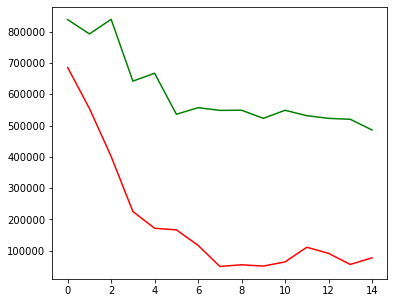

In [31]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [32]:
Y_pred = np.round(model.predict(X_test))

20/20 [==============================] - 5s 230ms/step


In [33]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 733.1768176020703
Test R^2 Score: 0.27673


In [34]:
image_sub = []

In [35]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [36]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [37]:
df_testpaths = testpaths.to_frame()

In [38]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [40]:
def image_processingsub(fil):
#Open image and import it as a numpy array
    image2 = imread(fil)
    
    image2 = cv2.resize(image2, (217, 217))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,image2.shape[0]):
        for j in range(0,image2.shape[1]):
            feature_matrix[i][j] = ((int(image2[i,j,0]) + int(image2[i,j,1]) + int(image2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [41]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processingsub(file))

100%|██████████| 20/20 [00:00<00:00, 20.69it/s]


In [42]:
X_sub = np.array(image_sub)

In [49]:
X_sub.shape

(20, 217, 217, 1)

In [48]:
X_train.shape

(1839, 217, 217, 1)

In [44]:
np.save('sub_image.npy',X_sub/255,allow_pickle=True)

In [45]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)

In [46]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 183ms/step


In [47]:
Y_sub

array([[358.],
       [390.],
       [352.],
       [158.],
       [424.],
       [568.],
       [505.],
       [426.],
       [410.],
       [449.],
       [164.],
       [328.],
       [397.],
       [425.],
       [362.],
       [546.],
       [267.],
       [340.],
       [314.],
       [551.]], dtype=float32)